## Tutorial 1: Getting started with EPI.

The epi python package implements emergent property inference (EPI) as described in [Bittner et al. 2019](https://www.biorxiv.org/content/10.1101/837567v2.abstract).  EPI learns distributions of model parameters that produce the emergent properties (or statistics) of interest, through optimization using deep learning.  EPI allows scientists to reason about the parametric sensitivity and robustness of models with respect ot the statistics (or "emergent properties") of their activity.  

In this tutorial, we will use EPI to infer the maximum entropy distribution of 2D linear dynamical system coefficients that produce oscillations near 1Hz.  For now, we'll focus on the basic functionality of the package.  In the subsequent tutorials, we will dive into the details of [augented Lagrangian optimization](link), [normalizing flow architectures](link), and [conditioning maximum-entropy distributions](link).  Those with specific use cases can also refer to [conditioning on data](link), and [consistency equations](link).

Throughout the tutorial, please refer to the API documentation at [https://epi.readthedocs.io/en/latest/API.html](https://epi.readthedocs.io/en/latest/API.html).

We will follow the same steps enumerated in Bittner et al. 2019 for using EPI:
1. Define the model.
2. Define the emergent property.
3. Run EPI.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# Mac OS jupyter kernel dies without.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### 1. Define the model.

In this tutorial, our model is a 2D linear dynamical system:

$\tau \dot{x} = Ax$, where $A = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix}$

For this example, let's assume we're interested in coefficients with magnitude at most 10.

$|a_{ij}| \leq 10$

To define our model, we will create  an instance of the [`epi.models.Model`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Model) class.  This class is initialized with a name, and list of parameters of type [`epi.models.Parameter`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Parameter).  First, we'll import the classes we need to define the model from [`epi.models`](https://epi.readthedocs.io/en/latest/API.html#epi.models).

In [2]:
from epi.models import Model, Parameter

Next, we create instances of the parameters of the model.  These parameters will define the distribution of parameters learned via EPI.  We must create a python object for each parameter of the model, which defines that parameter's name, dimensionality, and any bounds (see [`epi.model.Parameter`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Parameter).)

We can create a bounded univariate parameter for each dynamics coefficient in $A$, by setting $D=1$ and the lower and upper bounds to $\pm 10$.

`epi.model.Parameter(name, D=1, lb=-10., ub=10.)`

In [3]:
lb, ub, D = -10., 10., 1
a11 = Parameter("a11", D=D, lb=lb, ub=ub)
a12 = Parameter("a12", D=D, lb=lb, ub=ub)
a21 = Parameter("a21", D=D, lb=lb, ub=ub)
a22 = Parameter("a22", D=D, lb=lb, ub=ub)

Finally, we define the model by giving it a name, and providing it with a list of parameters (see [`epi.models.Model`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Model).)



In [4]:
name = "lds_2D"
params = [a11, a12, a21, a22]
M = Model(name, params)

Now, we've defined our model.  In principle, we know how to simulate activity $x \sim p(x \mid z)$ from our model, where $z$ are the parameters that make up the parameter list of our model

$z = \begin{bmatrix} a_{11} \\ a_{12} \\ a_{21} \\ a_{22} \end{bmatrix}$.

Next, we must define the emergent property we want our model to produce (step 2) in order to run EPI (step 3).

### 2. Define the emergent property.

Emergent property inference solves the following optimization problem:

$$\underset{q_\theta \in Q}{\mathrm{arg max}} \hspace{.2cm} H(q_\theta(z))$$

$$\text{s.t.} \mathbb{E}_{z \sim q_\theta}[ \mathbb{E}_{x \sim p(x \mid z)}[T(x)]] = \mu.$$

That is, EPI learns the distribution of parameters z, with maximal differential entropy $H(q_\theta(z))$ such that the emergent property is produced.  The emergent property is defined as the emergent property statistics $T(x)$ having mean value $\mu$ over the distribution of parameters $z \sim q_\theta$ and model activity $x \sim p(x \mid z)$.

EPI is a form of deep inference for learning flexible approximations to parameter distributions. The backend of this package uses Tensorflow for deep learning optimization.  To define the emergent property statistics of EPI, we will need to write a tensorflow function that calculates $\mathbb{E}_{x \sim p(x \mid z)}[T(x)]$ from the model parameters.  Since the 2D linear dynamical system model is deterministic, we will not concern ourselves in this example with averaging over stochasticity in $p(x \mid z)$.

We want to find the distribution of $A$ that results in a distribution of activity $x$ having oscillations near 1Hz.  This can be achieved by chosing the emergent propert statistics to be  the first and second moments of the primary eigenvalue $\lambda_1$ of $A$ (that with greater imaginary part or alternatively greater real part if imaginary parts are equal.)  

$\mathbb{E}[T(x)] \triangleq \begin{bmatrix} \text{real}(\lambda_1) \\ \text{imag}(\lambda_1) \\ (\text{real}(\lambda_1) - \mathbb{E}[\text{real}(\lambda_1)])^2 \\ (\text{imag}(\lambda_1) - \mathbb{E}[\text{imag}(\lambda_1)])^2 \end{bmatrix}$

#### Setting the emergent property statistics of model using `Model.set_eps`.

The key software development contribution of the `epi` python package user is to write a single tensorflow-compatible function -- that which calculates the emergent propert statistics from the model parameters.

Requirements of function `eps` passed to `Model.set_eps(eps)`:
1. Each argument of `eps(a, b, c)` has a unique matching parameter in `Model.parameters`, where the argument name (e.g. "a", "b", and "c" above) matches the name property `Paramater.name` of the matching parameter.
2. Each argument has dimensionality [batch size, D], where $D$ is the dimensionality of the matching parameter `Parameter.D`.
3. The function returns T(x) (type tf.Tensor) with dimensionality [batch size, m], where $m$ is the number of emergent property statistics.
4. The returned tensor must be differentiable with respect to all function arguments via `tf.GradientTape.gradient`.


Below is a tensorflow implementation of the emergent property statistics function for 2D linear dynamical system calculating the first and second .  We will use [`epi.models.Model.set_eps`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Model.set_eps) to set the emergent property statistics of our model for running EPI in step 3.

In [5]:
# Emergent property statistics
import tensorflow as tf

def linear2D_eig(a11, a12, a21, a22):
    tau = 1.0
    c11 = a11 / tau
    c12 = a12 / tau
    c21 = a21 / tau
    c22 = a22 / tau

    
    # Quadratic formula.
    real_term = 0.5 * (c11 + c22)
    complex_term = 0.5 * tf.sqrt(
        tf.complex(tf.square(c11 + c22) - 4.0 * (c11 * c22 - c12 * c21), 0.0)
    )
    real_lambda = real_term + tf.math.real(complex_term)
    imag_lambda = tf.math.imag(complex_term)

    T_x = tf.concat(
        (
            real_lambda,
            imag_lambda,
            tf.square(real_lambda - 0.),
            tf.square(imag_lambda - (2. * np.pi)),
        ),
        axis=1,
    )
    return T_x
M.set_eps(linear2D_eig)

To finish defining the emergent property, we must select the mean $\mu$ to constrain the first and second moment statistics.  Since we desire a distribution of systems with close to 1Hz  oscillations, we will constrain the $\mathbb{E}[\text{real}(\lambda_1)]$ to 0, and $\mathbb{E}[\text{imag}(\lambda_1)]$ to $2\pi f$, where $f = 1Hz$.  We allow some variation around these means from the distribution $z \sim q_\theta$ quantified by a standard deviation $\sigma_{\text{real}} = 0.5$ and $\sigma_{\text{imag}} = \pi / 5$. For an explanation of the  importance of second moment constraints, see the tutorial on [conditioning maximum-entropy distributions](link).  This completes our definition of the emergent property.

$\mathbb{E}[T(x)] \triangleq \begin{bmatrix} \text{real}(\lambda_1) \\ \text{imag}(\lambda_1) \\ (\text{real}(\lambda_1) - \mathbb{E}[\text{real}(\lambda_1)])^2 \\ (\text{imag}(\lambda_1) - \mathbb{E}[\text{imag}(\lambda_1)])^2 \end{bmatrix} = \begin{bmatrix} 0 \\ 1 \\ \sigma_{\text{real}}^2 \\ \sigma_{\text{imag}}^2 \end{bmatrix} \triangleq \mu$

In [6]:
# Emergent property values
mu = np.array([0.0, 2 * np.pi, 0.5**2, (0.2 * np.pi)**2])

### 3. Run emergent property inference.

Finally, we run EPI by invoking the [`epi.models.Model.epi`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Parameter) method.  This method has many optional arguments, the purpose of which will become clearer in tutorials on [augented Lagrangian optimization](link) and [normalizing flow architectures](link).  The only non-optional parameter is `mu`, which predicates the emergent property values.

This optimization will run for a default `K=10` augmented Lagrangian epochs, each with `num_iters=1000` iterations and a batch size of `N=500`.

In [7]:
q_theta, opt_data, save_path, flg = M.epi(
    mu, 
    c0=1e-3,
    stop_early=True,
    verbose=True,
    save_movie_data=True,
)

Initializing D4_C3_L2_U15_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/lds_2D_linear2D_eig//D4_C3_L2_U15_rs1/.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
EPI(k= 0,i=   0): cost  1.38E+03, H  5.71E+00, |R|^2 1.39E+03
EPI(k= 1,i=  50): cost -9.51E+00, H  9.90E+00, |R|^2 7.93E+02
EPI(k= 1,i= 100): cost -1.09E+01, H  1.14E+01, |R|^2 8.75E+02
EPI(k= 1,i= 150): cost -1.12E+01, H  1.16E+01, |R|^2 9.35E+02
EPI(k= 1,i= 200): cost -1.12E+01, H  1.17E+01, |R|^2 1.05E+03
EPI(k= 1,i= 250): cost -1.12E+01, H  1.17E+01, |R|^2 9.86E+02
EPI(k= 1,i= 300): cost -1.12E+01, H  1.17E+01, |R|^2 9.16E+02
EPI(k= 1,i= 350): cost -1.13E+01, H  1.17E+01, |R|^2 7.92E+02
EPI(k= 1,i= 400): cost -1.13E+01, H  1.17E+01, |R|^2 9.31E+02
EPI(k= 1,i= 450): cost -1.13E+01, H  

EPI(k= 6,i= 700): cost -8.14E+00, H  8.77E+00, |R|^2 1.52E+00
EPI(k= 6,i= 750): cost -8.06E+00, H  8.79E+00, |R|^2 1.89E+00
EPI(k= 6,i= 800): cost -8.11E+00, H  8.87E+00, |R|^2 2.00E+00
EPI(k= 6,i= 850): cost -8.10E+00, H  8.61E+00, |R|^2 1.11E+00
EPI(k= 6,i= 900): cost -8.13E+00, H  8.78E+00, |R|^2 1.58E+00
EPI(k= 6,i= 950): cost -8.15E+00, H  8.90E+00, |R|^2 1.94E+00
EPI(k= 6,i=1000): cost -8.07E+00, H  8.76E+00, |R|^2 1.74E+00
EPI(k= 7,i=  50): cost -7.83E+00, H  8.52E+00, |R|^2 7.42E-01
EPI(k= 7,i= 100): cost -7.81E+00, H  8.62E+00, |R|^2 9.69E-01
EPI(k= 7,i= 150): cost -7.89E+00, H  8.51E+00, |R|^2 6.15E-01
EPI(k= 7,i= 200): cost -7.83E+00, H  8.60E+00, |R|^2 8.96E-01
EPI(k= 7,i= 250): cost -7.87E+00, H  8.65E+00, |R|^2 9.75E-01
EPI(k= 7,i= 300): cost -7.86E+00, H  8.51E+00, |R|^2 6.73E-01
EPI(k= 7,i= 350): cost -7.80E+00, H  8.53E+00, |R|^2 8.37E-01
EPI(k= 7,i= 400): cost -7.93E+00, H  8.43E+00, |R|^2 4.34E-01
EPI(k= 7,i= 450): cost -7.85E+00, H  8.57E+00, |R|^2 7.94E-01
EPI(k= 7

First, [`epi.models.Model.epi`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Model.epi) optimizes the chosen normalizing flow architecture (the deep generative distribution of the model parameters) to a simple initial gaussian distribution.  This is done by optimizing the weights and biases of the normalizing flow  via variational inference to be as close as possible to the gaussian distribution chosen (default is standard isotropic gaussian).  Such initializations will be loaded from a cache when they have been run before on the current instance.  Optional parameters of this method can be set to specify a non-default normalizing flow architecture.

The method returns:
* `q_theta` - the inferred distribution of type [`epi.models.Distribution`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Distribution) which has methods like `q_theta.sample(N)`, `q_theta.log_prob(z)`, and `q_theta.hessian(z)`,
* `opt_data` - a pandas dataframe containing the optimization information.
* `save_dir` - the path to saved EPI distribution parameters, optimization information etc.
* `flg` - a boolean flag set to False if the optimization became unstable (nans and infs).

Each augmented Lagrangian epoch of EPI optimization runs (k=x) for 1000 iterations. After each epoch, the Lagrangian weights of the cost function are updated to adjust for the current level of constraint violation for each statistic of $T(x)$.  The relative weighting of constraint satisfaction to entropy in the objective increases at the beginning of each epoch, explaining the staircase trends in $H$ and $R_i$, where

$R_i = \mathbb{E}[T(x)_i] - \mu_i$

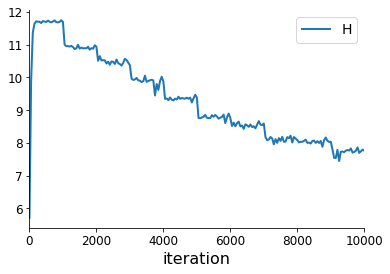

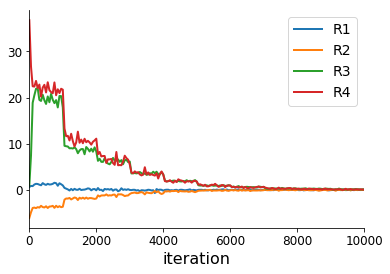

In [8]:
opt_data.plot('iteration', 'H')
opt_data.plot('iteration', ["R%d" % (i+1) for i in range(M.m)])

Finally, we can visualize the inferred distribution:

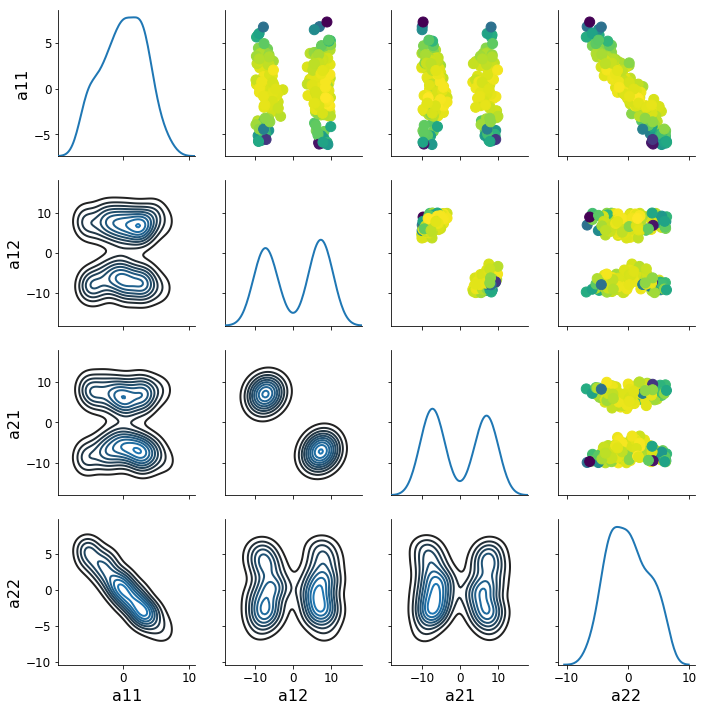

In [9]:
q_theta.plot_dist()

Or, we can create a movie visualizing the entirety of optimization.

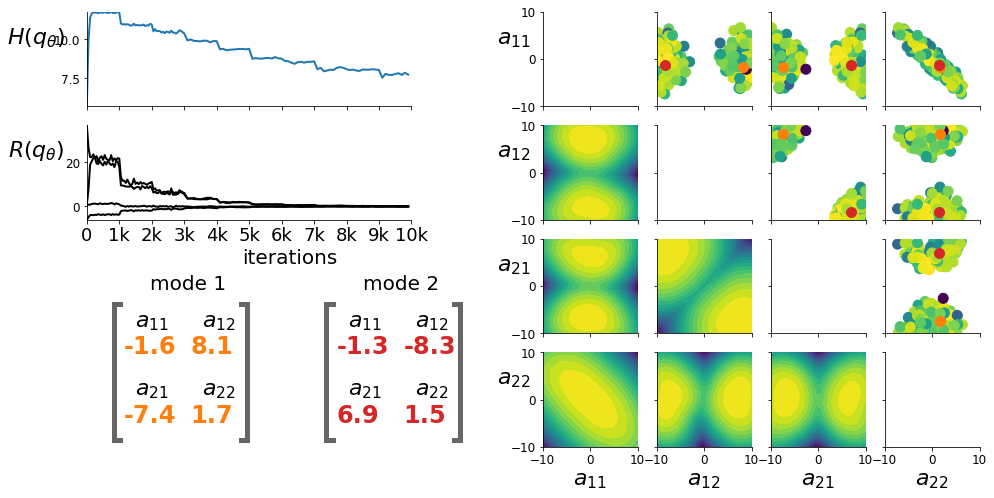

In [10]:
M.epi_opt_movie(save_path)